[From official `scikit-learn` documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html)<br>
Adapted by Claudio Sartori

# Classification with Decision Tree - hyperparameter tuning (__model selection__) with Grid Search and Cross Validation

We use here the Decision Tree and the standard `CrossValidation`, then find the best hyperparameter setting through _grid search_


### Workflow
1. download the data
1. data exploration
1. drop the useless data (if any)
1. separe the predicting attributes X from the class attribute y
1. split X and y into training and test
    - set a variable `target` with the column name of the target
1. single run with default parameters
    - initialise a estimator with the DecisionTreeClassifier
    - fit the estimator with the training part of X
    - show the tree structure
        - in particular, observe the maximum depth of the tree, this will be used in choosing the range for the `max_depth` hyperparameter
    - predict the y values with the fitted estimator and the train data
        - compare the predicted values with the true ones and compute the accuracy on the training set 
    - predict the y values with the fitted estimator and the test data
        - compare the predicted values with the true ones and compute the accuracy on the test set
        - this will be our baseline

## Model selection

- the *train* part will be used for training and _cross-validation_ (i.e. for *development*)
- the *test* part will be used for test (i.e. for *evaluation*)
- the fraction of test data will be __train_size__ (a value of your choice between 0.2 and 0.5)
- the function `GridSearchCV` iterates a cross validation experiment to __train__ and __validate__ a model with different combinations of paramater values
- for each parameter we set a list of values to test, the `GridSearchCV` function will generate all the combinations
- we will make several experiments with the optimisation of different *score function* 
    - e.g. `accuracy_score`, `precision_score`, `recall_score`, `f1_score`, see this [page](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) for reference
    - since the target is multiclass, consider the two versions of the score functions `_macro` and `_weighted` (not for the accuracy)
    - the output is a dictionary containing 
        - the set of parameters which maximize the score 
        - the test scores


In [1]:
"""
http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
@author: scikit-learn.org and Claudio Sartori
"""
import warnings
warnings.filterwarnings('ignore') # uncomment this line to suppress warnings



### Prepare the environment
The data file is located in `"../../data/winequality-red.csv"` on your github repository, the `target` is `quality

Prepare the data and the target in X and y. Set `ts`. Set the random state

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size'   : 10})
random_state = 19
train_size = 0.67
n_splits = 3
np.random.seed(random_state)
# the random state is reset here in numpy, all the scikit-learn procedure use the numpy random state
# obviously the experiment can be repeated exactly only with a complete run of the program

data_url = "../../data/winequality-red.csv"
sep = ';'
# sep = ','
target = 'quality'

Read the data into a dataframe and show the size

Shape of the input data (1599, 12)


In [4]:
# optional data modification, to merge quality levels 3 and 4
### Change quality label 3 to 4 in the dataframe
# print("quality value counts before:\n", df[target].value_counts().sort_index())
# df.loc[df[target] == 3, target] = 4
# print("quality value counts after:\n", df[target].value_counts().sort_index())

Have a quick look to the data.
- use the `.head()` function to see column names and some data
- use other exploration methods if you want

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


You could also explore the dataset, as you did in the previous labs, if you want.

Show an histogram of the target labels frequencies (hint: use the `value_counts` method)

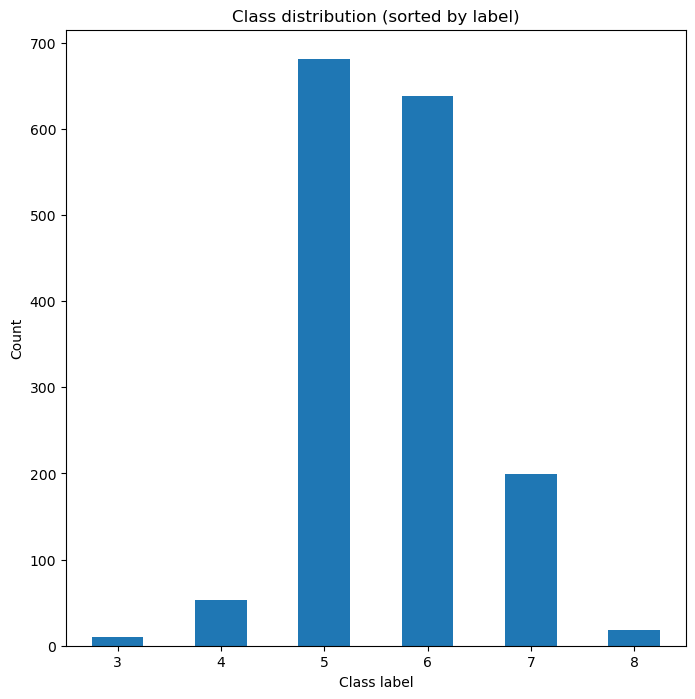

#### Split the data into the __predicting values__ `X` and the __target__ `y`
Drop also the columns which are not relevant for training a classifier, if any

The method "drop" of dataframes allows to drop either rows or columns
- the "axis" parameter chooses between dropping rows (axis=0) or columns (axis=1)

### Prepare the baseline: holdout method

There are 1071 samples in the training dataset
There are 528 samples in the testing dataset
Each sample has 11 features


- Initialize an estimator with the required model generator `tree.DecisionTreeClassifier(random_state = random_state)`
- Fit the estimator on the train data and target

DecisionTreeClassifier(random_state=19)

Predict the target for the training set and show the accuracy comparing the prediction with the ground truth for the trainin set

The accuracy on training set is 100.0%


Let's see how it works on test data, and, comparing with the result on training data, see if you can suspect *overfitting*
- use the fitted estimator to predict using the test features
- compute the accuracy and store it on a variable for the final summary
- store the maximum depth of the tree, for later use 
    - `fitted_max_depth = estimator.tree_.max_depth`
- store the range of the parameter which will be used for tuning
    - `parameter_values = range(1,fitted_max_depth+1)`
- print the accuracy on the test set and the maximum depth of the tree

The accuracy on test set is 63.3%
The maximum depth of the tree fitted on X_train is 17


Prepare the decision tree parameters and the scores 

In [12]:
# Set the parameters by cross-validation
tuned_param_dt = [{'max_depth': [*range(1,fitted_max_depth+1)] # try all depths from 1 to the unconstrained fitted one        
                   # the *       
                , 'criterion' : ['entropy', 'gini'] #
                , 'class_weight' : [None, 'balanced']}]

scores = ['precision_macro'
        , 'precision_weighted'
        , 'recall_macro'
        , 'recall_weighted'
        , 'f1_macro'
        , 'f1_weighted'
        , 'accuracy']

### Loop on scores
- initialize the splitter for the grid search `StratifiedKfold`, specifying the number of splits, the random_state and `shuffle=True`
- iterate varying the score function
    - fit the estimator using the training data
        - the resulting model will be the best one according to the current score function
    - print the best estimator
    - print the best score
    - predict the target for the test set using the `.predict` method
    - print the `classification_report`
    - generate the `confusion_matrix`
    - display the confusion matrix with `ConfusionMatrixDisplay`


Observation: the paired plots can be obtained with the `plt.subplots` command, but standard plots one by one are perfectly acceptable

# Tuning hyper-parameters for 'precision_macro'
{'class_weight': None, 'criterion': 'gini', 'max_depth': 9}
Best score 34.917%
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.20      0.12      0.15        17
           5       0.66      0.71      0.68       220
           6       0.59      0.56      0.58       206
           7       0.51      0.55      0.53        73
           8       0.00      0.00      0.00         8

    accuracy                           0.60       528
   macro avg       0.33      0.32      0.32       528
weighted avg       0.58      0.60      0.59       528

# Tuning hyper-parameters for 'precision_weighted'
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 14}
Best score 57.580%
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.05      0.06      0.06        17
           5       0.66      0

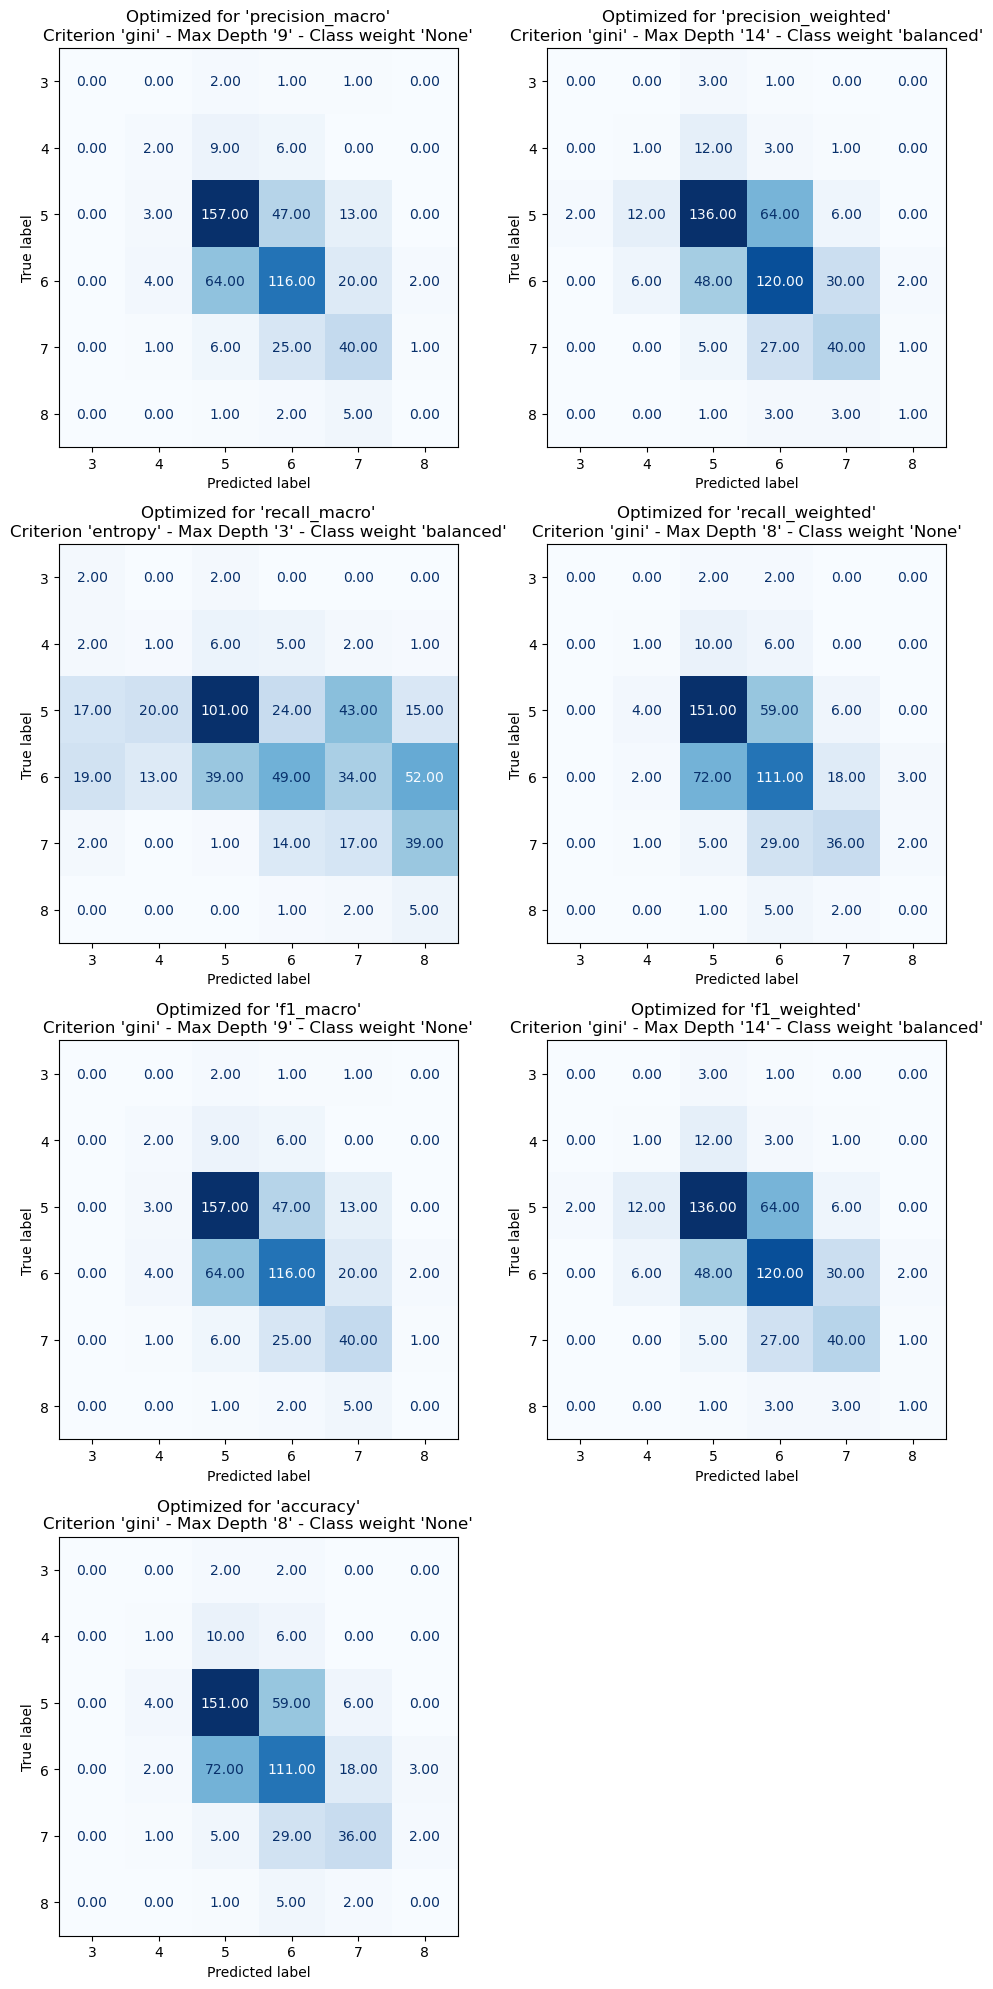

In [ ]:
## The following code block is ignored in the notebook, it is just to show how to collect all classification reports in a DataFrame
# from sklearn.metrics import classification_report

# # Collect classification reports for each score in a list of dicts
# reports = []
# for score in scores:
#     clf = GridSearchCV(
#         estimator=estimator,
#         param_grid=tuned_param_dt,
#         scoring=score,
#         return_train_score=False,
#         cv=skf
#     )
#     clf.fit(X_train, y_train)
#     y_pred = clf.best_estimator_.predict(X_test)
#     report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
#     report_dict['score_metric'] = score
#     reports.append(report_dict)

# # Flatten the reports for each class and metric
# flat_reports = []
# for rep in reports:
#     score_metric = rep.pop('score_metric')
#     for label, metrics in rep.items():
#         if isinstance(metrics, dict):
#             row = {'score_metric': score_metric, 'label': label}
#             row.update(metrics)
#             flat_reports.append(row)

# # Create DataFrame
# report_df = pd.DataFrame(flat_reports)
# report_df

In [15]:
# Print versions of key packages
import sys
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import seaborn as sns

print(f"Python version: {sys.version}")
print(f"pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"seaborn version: {sns.__version__}")


Python version: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:28:27) [Clang 14.0.6 ]
pandas version: 2.2.3
NumPy version: 1.26.4
scikit-learn version: 1.6.1
matplotlib version: 3.10.0
seaborn version: 0.13.2
